# Evaluation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# To run locally or on colab
colab = True
base_path = '../'

if colab:
    base_path = '/content/drive/MyDrive/ NLP - final project/'

Mounted at /content/drive


## Test of finetuned RoBERTa-base

In [2]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from transformers import TrainingArguments
from torch.utils.data import Dataset

# 1. CONFIGURATION
MODEL_PATH = f"{base_path}models"
TEST_TEXT_PATH = f"{base_path}Data/test.csv"
TEST_LABELS_PATH = f"{base_path}Data/test_labels.csv"

# 2. LOAD & PREPARE DATA
print("Loading test data...")

# Load the files
test_text = pd.read_csv(TEST_TEXT_PATH)
test_labels = pd.read_csv(TEST_LABELS_PATH)

test_df = test_text.merge(test_labels, on='id')

# Remove rows with label -1 (We found that Jigsaw uses -1 for excluded samples)
test_df = test_df[test_df['toxic'] != -1]

# Create the binary 'final_label' (Any toxic category = 1, otherwise 0)
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
test_df['final_label'] = test_df[label_cols].max(axis=1)

print(f"Valid Test Samples: {len(test_df)}")

# INITIALIZE MODEL
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_PATH
)

# Use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Create dataset
class ToxicityDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=128):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = str(self.data.iloc[index]['comment_text'])
        label = self.data.iloc[index]['final_label']

        # Tokenize the text
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }
test_dataset = ToxicityDataset(test_df, tokenizer)

# RUN EVALUATION USING TRAINER
trainer = Trainer(
    model=model,
    args=TrainingArguments(output_dir=f"{base_path}models/eval_output", per_device_eval_batch_size=64, report_to="none"),
)

print("Running prediction...")
predictions = trainer.predict(test_dataset)

# CALCULATE METRICS
preds = np.argmax(predictions.predictions, axis=-1)
probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=-1)[:, 1].numpy()
labels = predictions.label_ids

acc = accuracy_score(labels, preds)
f1 = f1_score(labels, preds)
roc = roc_auc_score(labels, probs)

print("\n" + "="*30)
print("   FULL TEST SET RESULTS")
print("="*30)
print(f"SAMPLES     : {len(test_df)}")
print(f"ACCURACY    : {acc:.4f}")
print(f"F1-SCORE    : {f1:.4f}")
print(f"ROC-AUC     : {roc:.4f}")
print("="*30)
print("\nClassification Report:")
print(classification_report(labels, preds, target_names=['Non-Toxic', 'Toxic']))

Loading test data...
Valid Test Samples: 63978
Running prediction...



   FULL TEST SET RESULTS
SAMPLES     : 63978
ACCURACY    : 0.9147
F1-SCORE    : 0.6758
ROC-AUC     : 0.9710

Classification Report:
              precision    recall  f1-score   support

   Non-Toxic       0.99      0.92      0.95     57735
       Toxic       0.54      0.91      0.68      6243

    accuracy                           0.91     63978
   macro avg       0.76      0.91      0.81     63978
weighted avg       0.95      0.91      0.92     63978



## Mistral 7B vs finetunedRoBERTa-base

Loading RoBERTa from /content/drive/MyDrive/ NLP - final project/models...
Running RoBERTa on 200 samples...

METRIC          | LLM (Mistral)   | RoBERTa (Yours)
--------------------------------------------------
ROC-AUC         | 0.94        | 1.00
F1-Score        | 0.6809          | 0.8780
Avg Latency     | 344.73 ms        | 10.47 ms
Speedup Factor  | 1.0x            | 32.9x FASTER


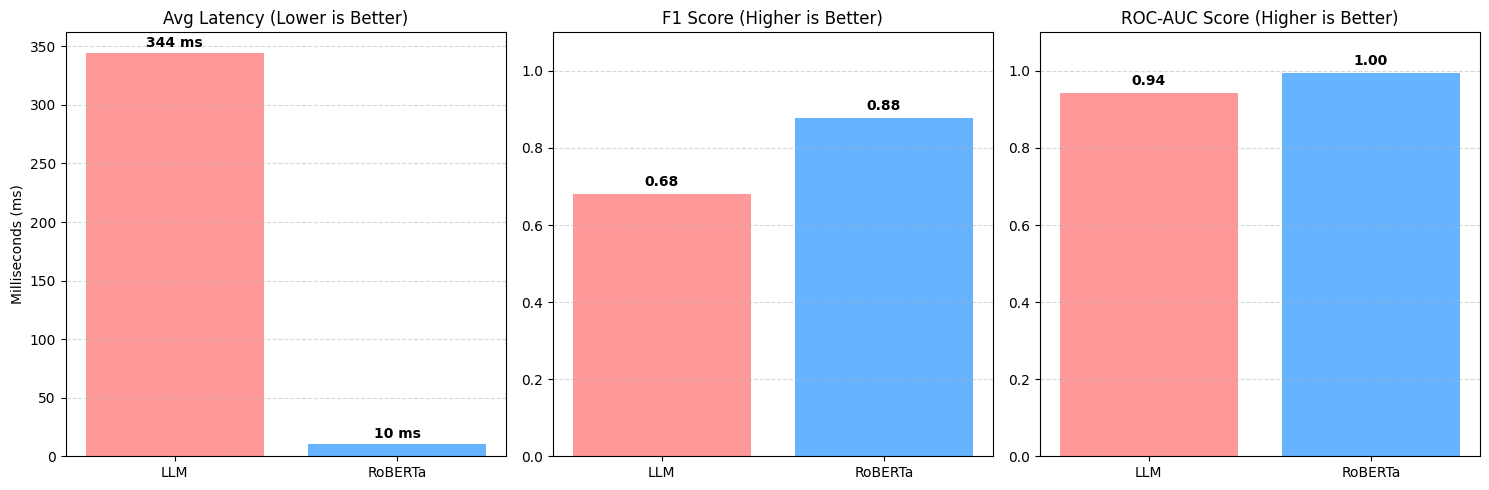

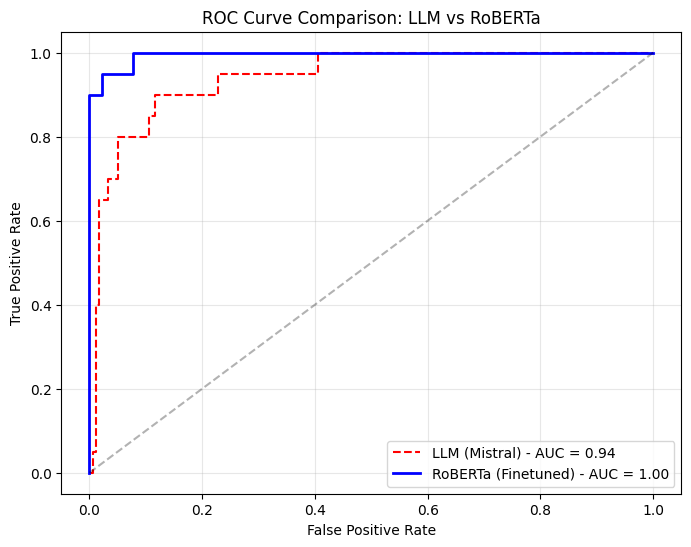

In [3]:
import torch
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve

# CONFIGURATION
ROBERTA_PATH = f"{base_path}models"
LLM_RESULTS_FILE = f"{base_path}Data/llm/mistral_prob_results.csv"
INPUT_FILE = f"{base_path}Data/llm/llm_baseline_inputs.csv"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. RUN ROBERTA INFERENCE
print(f"Loading RoBERTa from {ROBERTA_PATH}...")
tokenizer = AutoTokenizer.from_pretrained(ROBERTA_PATH)
model = AutoModelForSequenceClassification.from_pretrained(ROBERTA_PATH)
model.to(device)
model.eval()

df = pd.read_csv(INPUT_FILE)
print(f"Running RoBERTa on {len(df)} samples...")

roberta_preds = []
roberta_probs = []
roberta_latencies = []

for i, row in df.iterrows():
    text = str(row['llm_prompt'])

    start_time = time.time()

    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128, padding="max_length").to(device)
    with torch.no_grad():
        logits = model(**inputs).logits

    end_time = time.time()
    roberta_latencies.append((end_time - start_time) * 1000)

    probs = torch.softmax(logits, dim=-1).cpu().numpy()[0]
    roberta_probs.append(probs[1])
    roberta_preds.append(1 if probs[1] >= 0.5 else 0)

df['roberta_pred'] = roberta_preds
df['roberta_prob'] = roberta_probs
df['roberta_latency'] = roberta_latencies

# 2. LOAD LLM RESULTS & COMPARE
llm_df = pd.read_csv(LLM_RESULTS_FILE)
llm_latency_mean = llm_df['latency_ms'].mean()
llm_f1 = f1_score(llm_df['final_label'], llm_df['llm_pred'])
llm_auc = roc_auc_score(llm_df['final_label'], llm_df['toxicity_prob'])
llm_fpr, llm_tpr, _ = roc_curve(llm_df['final_label'], llm_df['toxicity_prob'])

# RoBERTa Metrics
roberta_latency_mean = np.mean(roberta_latencies)
roberta_f1 = f1_score(df['final_label'], df['roberta_pred'])
roberta_auc = roc_auc_score(df['final_label'], df['roberta_prob'])
rob_fpr, rob_tpr, _ = roc_curve(df['final_label'], roberta_probs)

# Print Side-by-Side Table
print("\n" + "="*50)
print(f"{'METRIC':<15} | {'LLM (Mistral)':<15} | {'RoBERTa (Yours)':<15}")
print("-" * 50)
print(f"{'ROC-AUC':<15} | {llm_auc:.2f}        | {roberta_auc:.2f}")
print(f"{'F1-Score':<15} | {llm_f1:.4f}          | {roberta_f1:.4f}")
print(f"{'Avg Latency':<15} | {llm_latency_mean:.2f} ms        | {roberta_latency_mean:.2f} ms")
print(f"{'Speedup Factor':<15} | {'1.0x':<15} | {llm_latency_mean/roberta_latency_mean:.1f}x FASTER")
print("="*50)


# 3. VISUALIZATION
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
models = ['LLM', 'RoBERTa']
colors = ['#ff9999', '#66b3ff']

# Subplot 1: Latency
axes[0].bar(models, [llm_latency_mean, roberta_latency_mean], color=colors)
axes[0].set_title('Avg Latency (Lower is Better)')
axes[0].set_ylabel('Milliseconds (ms)')
axes[0].grid(axis='y', linestyle='--', alpha=0.5)
for i, v in enumerate([llm_latency_mean, roberta_latency_mean]):
    axes[0].text(i, v + 5, f"{int(v)} ms", ha='center', fontweight='bold')

# Subplot 2: F1 Score
axes[1].bar(models, [llm_f1, roberta_f1], color=colors)
axes[1].set_title('F1 Score (Higher is Better)')
axes[1].set_ylim(0, 1.1)
axes[1].grid(axis='y', linestyle='--', alpha=0.5)
for i, v in enumerate([llm_f1, roberta_f1]):
    axes[1].text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')

# Subplot 3: ROC-AUC
axes[2].bar(models, [llm_auc, roberta_auc], color=colors)
axes[2].set_title('ROC-AUC Score (Higher is Better)')
axes[2].set_ylim(0, 1.1)
axes[2].grid(axis='y', linestyle='--', alpha=0.5)
for i, v in enumerate([llm_auc, roberta_auc]):
    axes[2].text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('comparison_metrics.png')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(llm_fpr, llm_tpr, label=f'LLM (Mistral) - AUC = {llm_auc:.2f}', linestyle='--', color='red')
plt.plot(rob_fpr, rob_tpr, label=f'RoBERTa (Finetuned) - AUC = {roberta_auc:.2f}', color='blue', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.3)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: LLM vs RoBERTa')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.savefig('comparison_roc_curve.png')
plt.show()